In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]
import gymnasium as gym

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. Tabular RL

In [57]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)

In [72]:
alphas = [0.3, 0.5, 0.7]
gamma = 0.99
temps = [0.005, 0.01, 0.05]

In [66]:
def boltzmann_exploration(state, q, temp):
    preference = q[state]/temp
    probabilities = np.exp(preference)/np.sum(np.exp(preference))
    return np.random.choice(4, p=probabilities)

In [67]:
def policy(state, q, temp):
    preference = q[state]/temp
    probabilities = np.exp(preference)/np.sum(np.exp(preference))
    return probabilities

## SARSA

In [80]:
sarsa_returns_train = np.zeros((3,3,10,5000))
sarsa_returns_test = np.zeros((3,3,10,500))

for r in range(10):

  print("Run",r+1)

  for i, alpha in enumerate(alphas):
    for j, temp in enumerate(temps):

      # initialize Q(s,a) for every state-action pair
      Q = np.zeros((env.observation_space.n, env.action_space.n))

      for s in range(500):

          # repeat for each training episode
          for e in range(10):
              observation, info = env.reset()
              # initialize s
              cur_state = 0
              # choose action to take in state s
              action = boltzmann_exploration(cur_state, Q, temp)
              # repeat for each step of episode
              terminated = False
              truncated = False
              step = 0
              while not terminated and not truncated:
                  # take action, observe reward and next state
                  observation, reward, terminated, truncated, info = env.step(action)
                  # choose action to take in state s'
                  next_state = observation
                  next_action = boltzmann_exploration(next_state, Q, temp)
                  # update state-action value
                  Q[cur_state, action] = Q[cur_state, action] + alpha*(reward+gamma*Q[next_state, next_action]-Q[cur_state, action])
                  # update cur_state and action
                  cur_state = next_state
                  action = next_action
                  step += 1
              disc_return = gamma**step*reward
              sarsa_returns_train[i,j,r,(s*10+e)] = disc_return

          # test
          observation, info = env.reset()
          terminated = False
          truncated = False
          step = 0
          while not terminated and not truncated:
              action = np.argmax(Q[observation])
              observation, reward, terminated, truncated, info = env.step(action)
              step += 1
          disc_return = gamma**step*reward
          sarsa_returns_test[i,j,r,s] = disc_return


Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10


## Expected SARSA

In [81]:
exp_sarsa_returns_train = np.zeros((3,3,10,5000))
exp_sarsa_returns_test = np.zeros((3,3,10,500))

for r in range(10):

  print("Run",r+1)

  for i, alpha in enumerate(alphas):
    for j, temp in enumerate(temps):

      Q = np.zeros((env.observation_space.n, env.action_space.n))

      for s in range(500):

          # repeat for each training episode
          for e in range(10):
              observation, info = env.reset()
              # initialize s
              cur_state = 0
              # choose action to take in state s
              action = boltzmann_exploration(cur_state, Q, temp)
              # repeat for each step of episode
              terminated = False
              truncated = False
              step = 0
              while not terminated and not truncated:
                  # take action, observe reward and next state
                  observation, reward, terminated, truncated, info = env.step(action)
                  # choose action to take in state s'
                  next_state = observation
                  next_action = boltzmann_exploration(next_state, Q, temp)
                  # update state-action value
                  expectation = np.dot(policy(next_state, Q, temp), Q[next_state])
                  Q[cur_state, action] = Q[cur_state, action] + alpha*(reward+gamma*expectation-Q[cur_state, action])
                  # update cur_state and action
                  cur_state = next_state
                  action = next_action
                  step += 1
              disc_return = gamma**step*reward
              exp_sarsa_returns_train[i,j,r,(s*10+e)] = disc_return

          # test
          observation, info = env.reset()
          terminated = False
          truncated = False
          step = 0
          while not terminated and not truncated:
              action = np.argmax(Q[observation])
              observation, reward, terminated, truncated, info = env.step(action)
              step += 1
          disc_return = gamma**step*reward
          exp_sarsa_returns_test[i,j,r,s] = disc_return


Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10


## Plot

### Final Performance

In [82]:
sarsa_final_train = np.mean(np.mean(sarsa_returns_train[:,:,:,4990:], axis=3), axis=2)
sarsa_final_test = np.mean(sarsa_returns_test[:,:,:,-1], axis=2)

exp_sarsa_final_train = np.mean(np.mean(exp_sarsa_returns_train[:,:,:,4990:], axis=3), axis=2)
exp_sarsa_final_test = np.mean(exp_sarsa_returns_test[:,:,:,-1], axis=2)

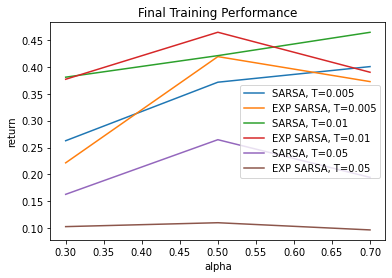

In [83]:
for i in range(3):
  plt.plot(alphas, sarsa_final_train[:,i], label="SARSA, T="+str(temps[i]))
  plt.plot(alphas, exp_sarsa_final_train[:,i], label="EXP SARSA, T="+str(temps[i]))

plt.xlabel("alpha")
plt.ylabel("return")
plt.title("Final Training Performance")
plt.legend()
plt.show()

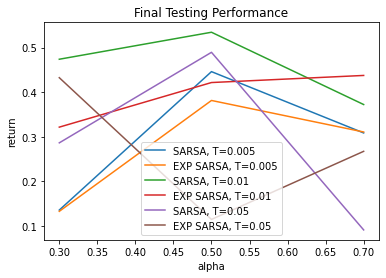

In [84]:
for i in range(3):
  plt.plot(alphas, sarsa_final_test[:,i], label="SARSA, T="+str(temps[i]))
  plt.plot(alphas, exp_sarsa_final_test[:,i], label="EXP SARSA, T="+str(temps[i]))

plt.xlabel("alpha")
plt.ylabel("return")
plt.title("Final Testing Performance")
plt.legend()
plt.show()

### Learning Curve

In [89]:
avg_sarsa_LC_train = np.mean(sarsa_returns_train[1,1], axis=0)
sarsa_train_std = np.std(sarsa_returns_train[1,1], axis=0)/np.sqrt(10)
avg_sarsa_LC_test = np.mean(sarsa_returns_test[1,1], axis=0)
sarsa_test_std = np.std(sarsa_returns_test[1,1],axis=0)/np.sqrt(10)

avg_exp_sarsa_LC_train = np.mean(exp_sarsa_returns_train[1,1], axis=0)
exp_sarsa_train_std = np.std(exp_sarsa_returns_train[1,1], axis=0)/np.sqrt(10)
avg_exp_sarsa_LC_test = np.mean(exp_sarsa_returns_test[1,1], axis=0)
exp_sarsa_test_std = np.std(exp_sarsa_returns_test[1,1],axis=0)/np.sqrt(10)

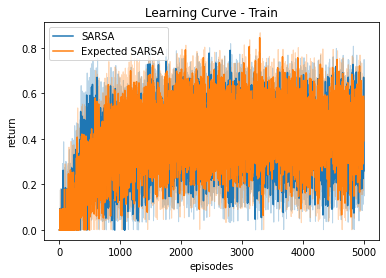

In [90]:
plt.plot(np.arange(5000),avg_sarsa_LC_train,label="SARSA", color='C0')
plt.fill_between(np.arange(5000), avg_sarsa_LC_train-sarsa_train_std, 
                 avg_sarsa_LC_train+sarsa_train_std, color='C0', alpha=0.3)

plt.plot(np.arange(5000),avg_exp_sarsa_LC_train,label="Expected SARSA", color='C1')
plt.fill_between(np.arange(5000), avg_exp_sarsa_LC_train-exp_sarsa_train_std, 
                 avg_exp_sarsa_LC_train+exp_sarsa_train_std, color='C1', alpha=0.3)

plt.xlabel("episodes")
plt.ylabel("return")
plt.title("Learning Curve - Train")
plt.legend()
plt.show()

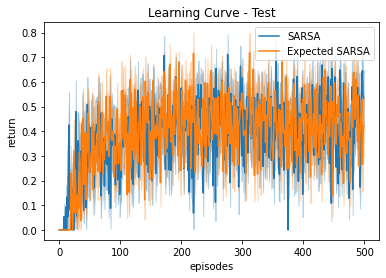

In [91]:
plt.plot(np.arange(500),avg_sarsa_LC_test,label="SARSA", color='C0')
plt.fill_between(np.arange(500), avg_sarsa_LC_test-sarsa_test_std, 
                 avg_sarsa_LC_test+sarsa_test_std, color='C0', alpha=0.3)

plt.plot(np.arange(500),avg_exp_sarsa_LC_test,label="Expected SARSA", color='C1')
plt.fill_between(np.arange(500), avg_exp_sarsa_LC_test-exp_sarsa_test_std, 
                 avg_exp_sarsa_LC_test+exp_sarsa_test_std, color='C1', alpha=0.3)

plt.xlabel("episodes")
plt.ylabel("return")
plt.title("Learning Curve - Test")
plt.legend()
plt.show()

# 2. Function Approximation

In [33]:
env = gym.make('CartPole-v1')

In [34]:
def one_hot(state):

  '''
  state: a (4,) numpy array from observation space
  return: a (10000,) numpy array which is the one-hot encoding of the state
          and index of the 1
  '''

  encoding = np.zeros(10000)
  bin_indicies = np.zeros(4)

  for i in range(4):
    for j in range(10):
      if state[i] >= BINS[i,j] and state[i] < BINS[i,j+1]:
        bin_indicies[i] = j
        break

  index = 0
  for i in range(4):
    index += bin_indicies[i]*10**(3-i)

  encoding[int(index)] = 1

  return encoding, int(index)

In [35]:
cart_pos_bin = np.linspace(-4.8,4.8,11)
cart_v_bin = np.linspace(-2^8,2^8,11)
pole_angle_bin = np.linspace(-0.418,0.418,11)
pole_angularV_bin = np.linspace(-2^8,2^8,11)
BINS = np.stack((cart_pos_bin, cart_v_bin, pole_angle_bin, pole_angularV_bin))

In [36]:
alphas = [1/16, 1/8, 1/4]
epsilons = [1, 0.7, 0.4]
gamma = 1
decay = 0.99

## Q-Learning

In [37]:
def epsilon_greedy(q, epsilon):

  if (random.random() < epsilon):
    action = random.randint(0,1) # pick a random action
  else:
    action = np.argmax(q) # greedy

  return action

In [38]:
returns = np.zeros((3,3,10,1000))

for r in range(10):

  print("run",r)

  np.random.seed(r) # only effects np.random and not random on its own
  
  for i, alpha in enumerate(alphas):
    for j, epsilon in enumerate(epsilons):
      print("-------")

      theta = np.random.uniform(-0.001, 0.001, (2,10000))

      for e in range(1000):

        # start at random initial state
        curr_state, info = env.reset(seed=r)
        
        terminated = False
        truncated = False
        
        while not terminated and not truncated:

          feature, curr_state_idx = one_hot(curr_state)

          # choose A from S using e-greedy
          curr_action = epsilon_greedy(theta[:,curr_state_idx], epsilon)

          # take action A, observe reward and next state
          next_state, reward, terminated, truncated, info = env.step(curr_action)

          # update Q(S,A)
          if terminated:
            target = reward
          else:
            _, next_state_idx = one_hot(next_state)
            target = reward+gamma*np.max(theta[:,next_state_idx])
          
          theta[curr_action] += alpha*(target-theta[curr_action,curr_state_idx])*feature

          curr_state = next_state

          # compute return
          returns[j,i,r,e] += 1

        epsilon *= decay
        
        if e%200==199:
          print(returns[j,i,r,e])

run 0
-------
20.0
20.0
20.0
20.0
20.0
-------
22.0
22.0
22.0
22.0
22.0
-------
13.0
11.0
11.0
11.0
11.0
-------
103.0
42.0
107.0
92.0
131.0
-------
92.0
153.0
89.0
89.0
89.0
-------
22.0
21.0
21.0
21.0
21.0
-------
90.0
93.0
108.0
108.0
108.0
-------
105.0
107.0
107.0
107.0
107.0
-------
78.0
128.0
143.0
143.0
143.0
run 1
-------
36.0
31.0
31.0
31.0
31.0
-------
9.0
12.0
51.0
51.0
51.0
-------
9.0
9.0
9.0
12.0
12.0
-------
40.0
97.0
96.0
96.0
138.0
-------
19.0
101.0
101.0
101.0
101.0
-------
15.0
15.0
15.0
15.0
15.0
-------
113.0
55.0
121.0
121.0
121.0
-------
44.0
123.0
156.0
156.0
156.0
-------
173.0
150.0
234.0
234.0
234.0
run 2
-------
33.0
54.0
54.0
54.0
54.0
-------
33.0
71.0
71.0
71.0
71.0
-------
22.0
22.0
22.0
22.0
22.0
-------
104.0
134.0
141.0
141.0
141.0
-------
62.0
113.0
105.0
105.0
105.0
-------
11.0
60.0
60.0
60.0
60.0
-------
15.0
176.0
166.0
251.0
251.0
-------
140.0
183.0
89.0
155.0
155.0
-------
21.0
32.0
151.0
151.0
151.0
run 3
-------
50.0
77.0
77.0
77.0
77.0
--

### Plot

In [39]:
avg_returns = np.mean(returns, axis=2)
stderr = np.std(returns, axis=2)/np.sqrt(10)

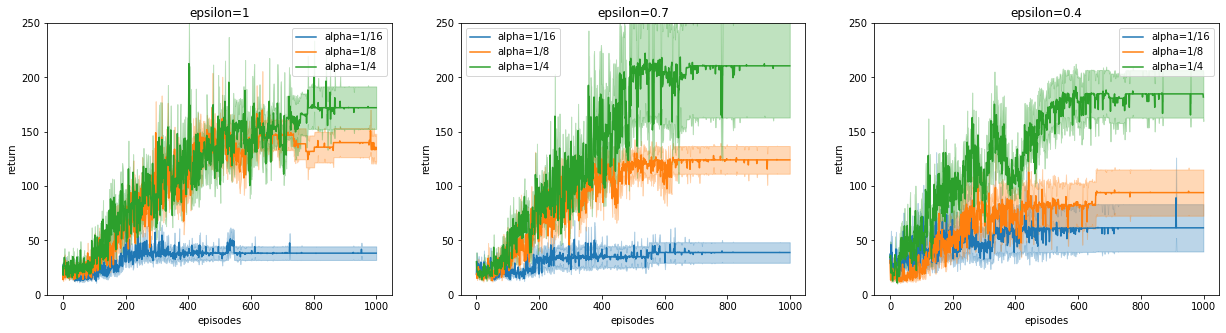

In [40]:
fig, axs = plt.subplots(1,3,figsize=(21,5))

for i in range(3):

  axs[i].plot(np.arange(1000), avg_returns[i,0,:], label="alpha=1/16", color='C0')
  axs[i].fill_between(np.arange(1000), avg_returns[i,0,:]-stderr[i,0,:], avg_returns[i,0,:]+stderr[i,0,:], color='C0', alpha=0.3)
  axs[i].plot(np.arange(1000), avg_returns[i,1,:], label="alpha=1/8", color='C1')
  axs[i].fill_between(np.arange(1000), avg_returns[i,1,:]-stderr[i,1,:], avg_returns[i,1,:]+stderr[i,1,:], color='C1', alpha=0.3)
  axs[i].plot(np.arange(1000), avg_returns[i,2,:], label="alpha=1/4", color='C2')
  axs[i].fill_between(np.arange(1000), avg_returns[i,2,:]-stderr[i,2,:], avg_returns[i,2,:]+stderr[i,2,:], color='C2', alpha=0.3)

  axs[i].set_title("epsilon="+str(epsilons[i]))
  axs[i].set_xlabel("episodes")
  axs[i].set_ylabel("return")
  axs[i].set_ylim(0,250)
  axs[i].legend()

plt.show()

## Actor-Critic

In [41]:
def softmax(state, theta):
  preference = np.array(theta[:,state]/TEMP, dtype=np.float128)
  probabilities = np.exp(preference)/np.sum(np.exp(preference))
  action = random.choices([0,1],weights=probabilities,k=1)[0]
  return action, probabilities

In [42]:
returns = np.zeros((10,3,1000))

for r in range(10):

  print("Run",r+1)

  for i, alpha in enumerate(alphas):

    print("-------")

    np.random.seed(r)
    theta = np.random.uniform(-0.001, 0.001, (2,10000))
    w = np.random.uniform(-0.001, 0.001, (10000,))

    TEMP = 5000
    DECAY = 0.99

    for e in range(1000):

      curr_state, info = env.reset(seed=r)

      truncated = False
      terminated = False

      while not terminated and not truncated:

        feature, curr_state_idx = one_hot(curr_state)

        curr_action, prob = softmax(curr_state_idx, theta)

        next_state, reward, terminated, truncated, info = env.step(curr_action)

        if terminated:
          delta = reward - w[curr_state_idx]
        else:
          _, next_state_idx = one_hot(next_state)
          delta = reward + w[next_state_idx] - w[curr_state_idx]

        w += alpha*delta*feature

        grad_pref = [np.stack([feature, np.zeros(10000)]), np.stack([np.zeros(10000), feature])]
        theta += alpha*delta*(1/TEMP*grad_pref[curr_action]-(prob[0]*grad_pref[0]+prob[1]*grad_pref[1]))

        curr_state = next_state

        returns[r,i,e] += 1

      TEMP *= DECAY
      if e%200==199:
        print(returns[r,i,e])

Run 1
-------
12.0
16.0
22.0
17.0
222.0
-------
28.0
22.0
14.0
15.0
71.0
-------
31.0
23.0
18.0
58.0
70.0
Run 2
-------
37.0
25.0
50.0
68.0
160.0
-------
24.0
19.0
19.0
48.0
193.0
-------
23.0
10.0
57.0
37.0
57.0
Run 3
-------
21.0
10.0
23.0
36.0
153.0
-------
20.0
19.0
15.0
82.0
239.0
-------
17.0
36.0
20.0
51.0
209.0
Run 4
-------
12.0
35.0
34.0
37.0
113.0
-------
12.0
28.0
46.0
26.0
140.0
-------
30.0
17.0
11.0
137.0
39.0
Run 5
-------
11.0
11.0
27.0
16.0
54.0
-------
40.0
17.0
32.0
13.0
25.0
-------
40.0
16.0
13.0
28.0
155.0
Run 6
-------
18.0
17.0
23.0
24.0
37.0
-------
12.0
12.0
33.0
51.0
161.0
-------
12.0
32.0
22.0
11.0
11.0
Run 7
-------
29.0
33.0
55.0
44.0
500.0
-------
23.0
29.0
25.0
155.0
112.0
-------
47.0
23.0
14.0
71.0
12.0
Run 8
-------
20.0
13.0
13.0
24.0
34.0
-------
21.0
22.0
13.0
107.0
75.0
-------
11.0
11.0
11.0
34.0
34.0
Run 9
-------
17.0
21.0
12.0
77.0
484.0
-------
15.0
51.0
28.0
44.0
251.0
-------
16.0
29.0
22.0
62.0
169.0
Run 10
-------
22.0
44.0
20.0
68.0
97

### Plot

In [43]:
avg_return = np.mean(returns, axis=0)
stderr = np.std(returns, axis=0)/np.sqrt(10)

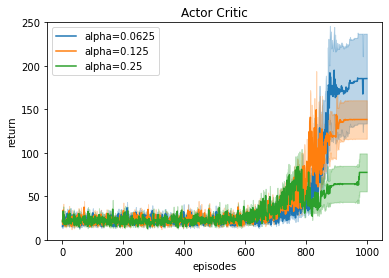

In [44]:
for i in range(3):
  plt.plot(np.arange(1000), avg_return[i,:], label="alpha="+str(alphas[i]), color='C'+str(i))
  plt.fill_between(np.arange(1000), avg_return[i,:]-stderr[i,:], avg_return[i,:]+stderr[i,:], color='C'+str(i), alpha=0.3)

plt.title("Actor Critic")
plt.xlabel("episodes")
plt.ylabel("return")
plt.ylim(0,250)
plt.legend()

plt.show()

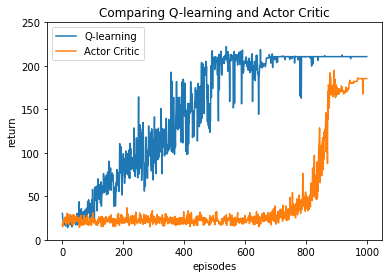

In [46]:
plt.plot(np.arange(1000), avg_returns[1,2], label="Q-learning")
plt.plot(np.arange(1000), avg_return[0], label="Actor Critic")

plt.title("Comparing Q-learning and Actor Critic")
plt.xlabel("episodes")
plt.ylabel("return")
plt.ylim(0,250)
plt.legend()

plt.show()